In [1]:
import pandas as pd
df = pd.read_csv('friends-personality.csv')

# df['character'] = df['character'].apply(lambda x: x.split()[0] if (x != 'Phoebe Sr.') else x)
df['raw_text'] = df['raw_text'].apply(lambda x: [[i.split('</b>:')[0].replace('<b>', ''), i.split('</b>:')[1]] for i in x.split('<br>') if "</b>:" in i ])


# use main role or not...

# main_roles = ['Chandler', 'Monica', 'Phoebe', 'Ross', 'Rachel', 'Joey']
# df = df[df['character'].isin(main_roles)]
df.head()

,Unnamed: 0,characters,raw_text,scene_id,cAGR,cCON,cEXT,cOPN,cNEU,single_text,full,single_context
0,0,Phoebe Buffay,"[[Monica Geller, Well, what happened?], [Phoe...",01_e12_c08(0),False,False,True,True,True,"speaker0 Well, he came in for a massage, and ...","speaker1 Well, what happened? speaker0 Well, ...","speaker0 Well, he came in for a massage, and ..."
1,1,Rachel,"[[Monica, (to Chandler) Anything but stew.], ...",03_e24_c04(0),False,False,True,True,False,"speaker0 Yeah. speaker0 Oh, ah with who?",speaker1 (to Chandler) Anything but stew. spe...,"speaker0 Yeah. speaker0 Oh, ah with who? spea..."
2,2,Eddie,"[[Eddie, Hey pal.], [Chandler Bing, Ahhhh-ga...",02_e19_c06(0),True,True,True,True,True,speaker0 Hey pal. speaker1 Ahhhh-gaaaahhh. Ed...,speaker0 Hey pal. speaker1 Ahhhh-gaaaahhh. Ed...,speaker0 Hey pal. speaker1 Ahhhh-gaaaahhh. Ed...
3,3,Phoebe Buffay,"[[Chandler Bing, Oh no no no, she's a total w...",02_e12_c05(0),True,False,True,True,True,"speaker0 No, uh-uh, I'm just, I'm nervous. So...","speaker1 Oh no no no, she's a total wack job....","speaker0 No, uh-uh, I'm just, I'm nervous. So..."
4,4,Chandler Bing,"[[Joey Tribbiani, Uh, hey, Dr. Greene, why do...",02_e22_c03(1),False,False,False,False,False,"speaker0 Yes because uh, you look so young. s...","speaker1 Uh, hey, Dr. Greene, why don't you c...","speaker0 Yes because uh, you look so young. s..."


In [2]:
df_labels = df[['cAGR','cCON','cEXT','cOPN','cNEU']]
df_counts = pd.DataFrame([])
df_counts['AGR'] = df_labels['cAGR'].value_counts().reset_index()['cAGR']
df_counts['CON'] = df_labels['cCON'].value_counts().reset_index()['cCON']
df_counts['EXT'] = df_labels['cEXT'].value_counts().reset_index()['cEXT']
df_counts['OPN'] = df_labels['cOPN'].value_counts().reset_index()['cOPN']
df_counts['NEU'] = df_labels['cNEU'].value_counts().reset_index()['cNEU']
df_counts

,AGR,CON,EXT,OPN,NEU
0,405,381,399,462,379
1,306,330,312,249,332


In [6]:
[306/711.0, 330/711.0, 312/711.0, 249/711.0, 332/711.0]

[0.43037974683544306,
 0.4641350210970464,
 0.4388185654008439,
 0.350210970464135,
 0.4669479606188467]

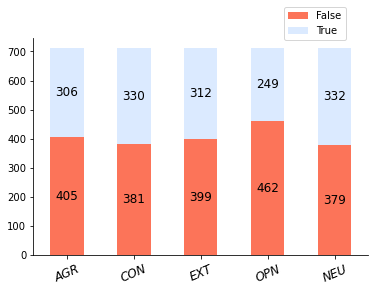

In [3]:
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize

import seaborn as sns
# sns.set(style="white")


df_counts.index = (['False', 'True'])
ax = df_counts.T.plot.bar(stacked=True, color=['#FC7459', '#DBEAFF'])
# ax.color_palette("pastel")
# annotate the bars
for i, rect in enumerate(ax.patches):
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the count value and can used as the label
    label_text = f'{height:.0f}'

    label_x = x + width / 2
    label_y = y + height / 2

    # don't include label if it's equivalently 0
    if height > 0.001:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)

ax.set_xticklabels(df_counts.columns, rotation=23, fontsize=12, fontstyle='oblique', fontweight='550')
ax.legend(bbox_to_anchor=(0.75, 0.99), loc=0, borderaxespad=0.0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
plt.savefig('plot123_2.png', dpi=300)

In [371]:
a = [0.659, 0.627, 0.639, 0.689, 0.643]
import numpy as np
np.std(a)

0.021406541056415426

In [4]:
def get_text_role(sent_list, role):
    '''
    Extract the utterances from the given role
    '''
    ans = ""
    for i in sent_list:
        ## if i[0].split(' ')[0] == role and i[0] != 'Phoebe Sr.':
        if i[0] == role:
            ans = ans + ' ' + i[1]
    return ans

def get_context_role(sent_list, role):
    '''
    Extract the utterances not from the given role
    '''
    ans = ""
    for i in sent_list:
        # if i[0].split(' ')[0] != role or i[0] == 'Phoebe Sr.':
        if i[0] != role:
            ans = ans + ' ' + i[1]
    return ans


from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
MAX_LEN   = 128


def get_seg_id(sent_list, role):
    '''
    Generate the segment id for the whole sent
    '''

    ans = []
   
    for i in sent_list:
        if i[0].split(' ')[0] != role.split(' ')[0]:
            
            ans.append(0)
        else:
            ans.append(1)


    return ans

def get_sent(sent_list, role):
    '''
    Obtain the whole sent
    '''
    
    ans = ""
    for i in sent_list:
        ans = ans + i[1]
    return ans

df_A = df[['scene_id', 'raw_text', 'characters', 'cAGR']]
df_C = df[['scene_id', 'raw_text', 'characters', 'cCON']]
df_E = df[['scene_id', 'raw_text', 'characters', 'cEXT']]
df_O = df[['scene_id', 'raw_text', 'characters', 'cOPN']]
df_N = df[['scene_id', 'raw_text', 'characters', 'cNEU']]

df_A['dialog_state'] = df_A.apply(lambda r: get_seg_id(r['raw_text'], r['characters']), axis=1)
df_C['dialog_state'] = df_C.apply(lambda r: get_seg_id(r['raw_text'], r['characters']), axis=1)
df_E['dialog_state'] = df_E.apply(lambda r: get_seg_id(r['raw_text'], r['characters']), axis=1)
df_O['dialog_state'] = df_O.apply(lambda r: get_seg_id(r['raw_text'], r['characters']), axis=1)
df_N['dialog_state'] = df_N.apply(lambda r: get_seg_id(r['raw_text'], r['characters']), axis=1)

df_A['sent'] = df_A.apply(lambda r: get_sent(r['raw_text'], r['characters']), axis=1)
df_C['sent'] = df_C.apply(lambda r: get_sent(r['raw_text'], r['characters']), axis=1)
df_E['sent'] = df_E.apply(lambda r: get_sent(r['raw_text'], r['characters']), axis=1)
df_O['sent'] = df_O.apply(lambda r: get_sent(r['raw_text'], r['characters']), axis=1)
df_N['sent'] = df_N.apply(lambda r: get_sent(r['raw_text'], r['characters']), axis=1)

df_A['utterance'] = df_A.apply(lambda r: get_text_role(r['raw_text'], r['characters']), axis=1)
df_C['utterance'] = df_C.apply(lambda r: get_text_role(r['raw_text'], r['characters']), axis=1)
df_E['utterance'] = df_E.apply(lambda r: get_text_role(r['raw_text'], r['characters']), axis=1)
df_O['utterance'] = df_O.apply(lambda r: get_text_role(r['raw_text'], r['characters']), axis=1)
df_N['utterance'] = df_N.apply(lambda r: get_text_role(r['raw_text'], r['characters']), axis=1)

df_A['context'] = df_A.apply(lambda r: get_context_role(r['raw_text'], r['characters']), axis=1)
df_C['context'] = df_C.apply(lambda r: get_context_role(r['raw_text'], r['characters']), axis=1)
df_E['context'] = df_E.apply(lambda r: get_context_role(r['raw_text'], r['characters']), axis=1)
df_O['context'] = df_O.apply(lambda r: get_context_role(r['raw_text'], r['characters']), axis=1)
df_N['context'] = df_N.apply(lambda r: get_context_role(r['raw_text'], r['characters']), axis=1)

df_A['labels'] = df_A['cAGR'].apply(lambda x: 1 if x is True else 0)
df_C['labels'] = df_C['cCON'].apply(lambda x: 1 if x is True else 0)
df_E['labels'] = df_E['cEXT'].apply(lambda x: 1 if x is True else 0)
df_O['labels'] = df_O['cOPN'].apply(lambda x: 1 if x is True else 0)
df_N['labels'] = df_N['cNEU'].apply(lambda x: 1 if x is True else 0)


df_A.to_csv('Friends_A_whole.tsv', sep='\t') 
df_C.to_csv('Friends_C_whole.tsv', sep='\t')
df_E.to_csv('Friends_E_whole.tsv', sep='\t')
df_O.to_csv('Friends_O_whole.tsv', sep='\t')
df_N.to_csv('Friends_N_whole.tsv', sep='\t')

/tmp/ipykernel_10376/1110531162.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_A['dialog_state'] = df_A.apply(lambda r: get_seg_id(r['raw_text'], r['characters']), axis=1)
/tmp/ipykernel_10376/1110531162.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C['dialog_state'] = df_C.apply(lambda r: get_seg_id(r['raw_text'], r['characters']), axis=1)
/tmp/ipykernel_10376/1110531162.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [5]:
df_A.head()

,scene_id,raw_text,characters,cAGR,dialog_state,sent,utterance,context,labels
0,01_e12_c08(0),"[[Monica Geller, Well, what happened?], [Phoe...",Phoebe Buffay,False,"[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1]","Well, what happened? Well, he came in for a m...","Well, he came in for a massage, and everythi...","Well, what happened? Ooooohh! My God. Are...",0
1,03_e24_c04(0),"[[Monica, (to Chandler) Anything but stew.], ...",Rachel,False,"[0, 0, 0, 0, 0, 1, 0, 1]",(to Chandler) Anything but stew. All right so...,"Yeah. Oh, ah with who?",(to Chandler) Anything but stew. All right ...,0
2,02_e19_c06(0),"[[Eddie, Hey pal.], [Chandler Bing, Ahhhh-ga...",Eddie,True,"[1, 0, 1, 0, 1, 0]",Hey pal. Ahhhh-gaaaahhh. Eddie what're you st...,"Hey pal. Ah, just some basic dehydrating of...",Ahhhh-gaaaahhh. Eddie what're you still doin...,1
3,02_e12_c05(0),"[[Chandler Bing, Oh no no no, she's a total w...",Phoebe Buffay,True,"[0, 0, 0, 0, 0, 1, 0]","Oh no no no, she's a total wack job. Yeah, sh...","No, uh-uh, I'm just, I'm nervous. So, you kn...","Oh no no no, she's a total wack job. Yeah, s...",1
4,02_e22_c03(1),"[[Joey Tribbiani, Uh, hey, Dr. Greene, why do...",Chandler Bing,False,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]","Uh, hey, Dr. Greene, why don't you come with ...","Yes because uh, you look so young. NO! No, ...","Uh, hey, Dr. Greene, why don't you come with...",0


In [382]:
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
df_A['tokens'] = [tokenizer.encode(sent, add_special_tokens=False,
            pad_to_max_length=False) for sent in df_A['sent']]

Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


In [385]:
df_A['tokens_len'] = df_A['tokens'].apply(lambda x:len(x))
df_A['num_uttr'] = df_A['dialog_state'].apply(lambda x:len(x))
df_A['uttr_len'] = df_A['tokens_len']/df_A['num_uttr']
df_A['uttr_len'].describe()

count    711.000000
mean      16.269433
std        5.708456
min        3.250000
25%       12.267857
50%       15.500000
75%       19.522727
max       42.250000
Name: uttr_len, dtype: float64

In [209]:
print(type(df_A['utterance'][0]))

cnt = 0
for i in df_A['utterance']:
    cnt += 1
    if type(i) != str:
        print(cnt)

<class 'str'>


In [206]:
print(df_A.iloc[581]['text'])

[['Monica', ' What are you doing?'], ['Phoebe', " No, I'm really okay with this. Y'know why? 'Cause look at them, and I made that, so... I know it's gonna be like a million times harder to give up a baby but, oh my God, it's gonna feel like a million times better, right? I wanna do this. (To Frank and Alice) I wanna carry your baby."], ['Alice', " (shocked) Oh! Oh! Oh! Thank you so much! You don't know what this means to us! Oh!"], ['Frank', " Oh my God, I think I'm gonna cry!"], ['Monica', " It's gonna be so great."], ['Phoebe Sr.', " (entering) Hi! What's going on?"]]


In [227]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,IterableDataset
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import json
import re

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)



df_A = pd.read_csv('Friends_A_whole.tsv', sep='\t')
sents = [tokenizer.encode(sent, add_special_tokens=True, max_length=64, \
                pad_to_max_length=True) for sent in df_A['text']]



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/zhiyuan/ENTER/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2173: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  """


In [231]:
df_A.head()

,Unnamed: 0,scene_id,text,character,cAGR,dialog_state,sent,utterance,context,labels
0,0,01_e01_c01,"[['Ross Geller', "" No!! Okay?! Why does everyo...",Joey Tribbiani,1,"[0, 0, 0, 0, 0, 0, 0, 0]",No!! Okay?! Why does everyone keep fixating o...,"Alright Ross, look. You're feeling a lot of ...",No!! Okay?! Why does everyone keep fixating ...,1
1,1,01_e01_c02,"[['Monica Geller', "" Now I'm guessing that he ...",Chandler Bing,1,"[0, 0, 0, 0, 0, 0, 0]",Now I'm guessing that he bought her the big p...,(imitating the characters) Tuna or egg salad...,Now I'm guessing that he bought her the big ...,1
2,2,01_e01_c04,"[['Ross Geller', "" (squatting and reading the ...",Chandler Bing,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",(squatting and reading the instructions) I'm ...,It's a beautiful thing. I would have to say...,(squatting and reading the instructions) I'm...,0
3,3,01_e01_c05,"[['Monica Geller', ' Oh my God!'], ['Paul', "" ...",Paul,1,"[0, 1, 0, 1, 0]","Oh my God! I know, I know, I'm such an idiot....","I know, I know, I'm such an idiot. I guess I...",Oh my God! My brother's going through that ...,1
4,4,01_e01_c08,"[['Paul', ' Ever since she walked out on me, I...",Monica Geller,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","Ever since she walked out on me, I, uh... Wha...","What?..... What, you wanna spell it out with...","Ever since she walked out on me, I, uh... N...",1


In [238]:
import pandas as pd
import string
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

VAD_Lexicons = pd.read_csv('NRC-VAD-Lexicon-Aug2018Release/NRC-VAD-Lexicon.txt', sep='\t')
VAD_dict = {}
for r in VAD_Lexicons.iterrows():
    VAD_dict[r[1]['Word']] = [r[1]['Valence'], r[1]['Arousal'], r[1]['Dominance']]
VAD_dict = VAD_dict


cnt = 0
raw_match = 0
match = 0

token_set = set([])
matched_set = set([])


for i,r in df_A.iterrows():
    raw_sent = r['sent'] 
    sent = raw_sent
    try:
        sent_ids = tokenizer.encode(raw_sent, add_special_tokens=False)
        for i in sent_ids:
            tmp = tokenizer.decode(i).replace(' ', '')
            if not tmp in string.punctuation:
                token_set.add(tmp)
                cnt += 1
                try:
                    VAD_dict[tmp]
                    matched_set.add(tmp)
                    match += 1
                except:
                    pass
    except:
        print(r['sent'])
print(cnt)
print(match)

print(len(token_set))
print(len(matched_set))

Token indices sequence length is longer than the specified maximum sequence length for this model (640 > 512). Running this sequence through the model will result in indexing errors


96801
27669
5346
2796


In [236]:
sent_ids = tokenizer.encode(df_A['sent'][0], add_special_tokens=True)
for i in sent_ids:
    tmp = tokenizer.decode(i).replace(' ', '')
    if not tmp in string.punctuation:
        print(tmp)

[CLS]
no
okay
why
does
everyone
keep
fix
##ating
on
that
she
didn
t
know
how
should
i
know
sometimes
i
wish
i
was
a
lesbian
they
all
stare
at
him
did
i
say
that
out
loud
i
told
mom
and
dad
last
night
they
seemed
to
take
it
pretty
well
oh
really
so
that
hysterical
phone
call
i
got
from
a
woman
at
sobbing
3
00
a
m
i
ll
never
have
grandchildren
i
ll
never
have
grandchildren
was
what
a
wrong
number
sorry
alright
ross
look
you
re
feeling
a
lot
of
pain
right
now
you
re
angry
you
re
hurting
can
i
tell
you
what
the
answer
is
strip
joint
c
mon
you
re
single
have
some
hormones
i
don
t
want
to
be
single
okay
i
just
i
just
i
just
wanna
be
married
again
[SEP]


In [222]:
print(df_A.iloc[0]['text'])

[['Ross Geller', " No!! Okay?! Why does everyone keep fixating on that? She didn't know, how should I know?"], ['Chandler Bing', ' Sometimes I wish I was a lesbian... (They all stare at him.) Did I say that out loud?'], ['Ross Geller', ' I told mom and dad last night, they seemed to take it pretty well.'], ['Monica Geller', ' Oh really, so that hysterical phone call I got from a woman at sobbing 3:00 A.M., "I\'ll never have grandchildren, I\'ll never have grandchildren." was what? A wrong number?'], ['Ross Geller', ' Sorry.'], ['Joey Tribbiani', " Alright Ross, look. You're feeling a lot of pain right now. You're angry. You're hurting. Can I tell you what the answer is?"], ['Joey Tribbiani', " Strip joint! C'mon, you're single! Have some hormones!"], ['Ross Geller', " I don't want to be single, okay? I just... I just- I just wanna be married again!"]]


In [223]:
print(df_A.iloc[0]['character'])
print(df_A.iloc[0]['utterance'])

Joey Tribbiani
  Alright Ross, look. You're feeling a lot of pain right now. You're angry. You're hurting. Can I tell you what the answer is?  Strip joint! C'mon, you're single! Have some hormones!


In [224]:
print(df_A.iloc[0]['context'])

  No!! Okay?! Why does everyone keep fixating on that? She didn't know, how should I know?  Sometimes I wish I was a lesbian... (They all stare at him.) Did I say that out loud?  I told mom and dad last night, they seemed to take it pretty well.  Oh really, so that hysterical phone call I got from a woman at sobbing 3:00 A.M., "I'll never have grandchildren, I'll never have grandchildren." was what? A wrong number?  Sorry.  I don't want to be single, okay? I just... I just- I just wanna be married again!


In [226]:
lengths = [len(i) for i in df_A['dialog_state']]
print(sum(lengths))
print(sum(lengths)/float(len(lengths)))
cnt = 0
for i,r in df_O.iterrows():
    cnt +=  len(r['text']) 
print(cnt)

8157
11.472573839662447
8157


In [103]:
def get_vad(VAD_dict, sents, tokenizer):
    VAD_scores = []
    for sent in sents:
        w_list = re.sub(r'[^\w\s\[\]]','',tokenizer.decode(sent)).split()
        v_score, a_score, d_score = 0, 0, 0
        for word in w_list:
            try:
                v_score += VAD_dict[word][0]
                a_score += VAD_dict[word][1]
                d_score += VAD_dict[word][2]
            except:
                v_score += 0
                a_score += 0
                d_score += 0

        v_score/=float(len(w_list))
        a_score/=float(len(w_list))
        d_score/=float(len(w_list))
        VAD_scores.append([v_score, a_score, d_score])
    return VAD_scores

[get_vad(VAD_dict,sent) for sent in contexts]

NameError: name 'VAD_dict' is not defined